<a href="https://colab.research.google.com/github/fahimabrar/Natural-Language-Processing/blob/main/Spam%20Classification/Spam_Classification(CNN%2CRNNs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Classification of Spam and Non Spam message using Deep Learning

## This NoteBook Covers
- Reading data from Tab delimited binray files
- Data Tokenization, Padding to fixed length vectors
- Embedding using keras embedding layers
- Training Convolutioal Neural Network, Gated Reccurent Unit, Long Short term Memory deep learning methods
- Highest accuracy obtained 98.95 using CNN, LSTM
- Used both Keras Sequential and Functional API


In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import numpy as np
np.random.seed(500)

In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import LSTM, GRU, Embedding
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score
import pickle

In [68]:

df = pd.DataFrame(pd.read_csv("https://raw.githubusercontent.com/fahimabrar/Natural-Language-Processing/main/Spam%20Classification/spam", sep='\t', names= ["label", "message"]))
df.tail()


,label,message
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


## Data Preprocessing

In [4]:
import numpy as np
import nltk
nltk.download("punkt")
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import string
import re
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
def preprocess(sentence):
  sentence.translate(str.maketrans('', '', string.punctuation))
  tokens = nltk.word_tokenize(sentence)
  tokens = [word.lower() for word in tokens]
  tokens = [wordnet_lemmatizer.lemmatize(word, pos="v") for word in tokens]
  tokens = [word for word in tokens if len(word)>1]
  clean_sentence = ' '.join(tokens)
  return clean_sentence


In [6]:
df["message"] = df.message.apply(preprocess)

In [7]:
message = list(df.message)
label = list(df.label)
label = list(pd.get_dummies(label, drop_first = True)['spam'])
df.shape

(5572, 2)

In [8]:
vocab_size = 10000
max_length = 40
embedding_dim = 32
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 20000

In [9]:
training_sentences = message[0:5000]
training_labels = label[0:5000]
testing_sentences = message[5000:]
testing_labels = label[5000:]

In [10]:
tokenizer = Tokenizer(num_words= vocab_size, oov_token= oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
len(word_index)
#word_index

7540

In [11]:
train_seqs = tokenizer.texts_to_sequences(training_sentences)
train_padded = pad_sequences(train_seqs, maxlen =  max_length, padding=padding_type, truncating= trunc_type)
test_seqs = tokenizer.texts_to_sequences(testing_sentences)
test_padded = pad_sequences(test_seqs, maxlen =  max_length, padding= padding_type, truncating= trunc_type)

In [12]:
train_padded

array([[  19,  412, 3653, ...,    0,    0,    0],
       [  48,  333,  719, ...,    0,    0,    0],
       [  51,  477,    8, ...,    0,    0,    0],
       ...,
       [ 129,   97,  258, ...,    0,    0,    0],
       [2081,   82,  110, ...,    0,    0,    0],
       [  29,    4,  225, ...,    0,    0,    0]], dtype=int32)

In [13]:
test_padded.shape

(572, 40)

In [14]:
train_padded = np.array(train_padded)
test_padded = np.array(test_padded)
train_labels = np.array(training_labels)
test_labels = np.array(testing_labels)

# LSTM

In [34]:
# defining the model woth keras functional API
input = Input(shape=(max_length,))
x = Embedding(vocab_size, embedding_dim, input_length=max_length)(input)
x = LSTM(64, return_sequences = True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(32, activation='relu')(x) 
output = Dense(1, activation='sigmoid')(x)
model = Model(input, output)

In [35]:
model.summary()
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 40, 32)            320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 64)            24832     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 346,945
Trainable params: 346,945
Non-trainable params: 0
_____________________________________________________

In [36]:
num_epochs = 5
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels), verbose=2)

Epoch 1/5
157/157 - 7s - loss: 0.2376 - accuracy: 0.9260 - val_loss: 0.0604 - val_accuracy: 0.9878
Epoch 2/5
157/157 - 4s - loss: 0.0441 - accuracy: 0.9904 - val_loss: 0.0394 - val_accuracy: 0.9878
Epoch 3/5
157/157 - 4s - loss: 0.0289 - accuracy: 0.9936 - val_loss: 0.0294 - val_accuracy: 0.9913
Epoch 4/5
157/157 - 4s - loss: 0.0152 - accuracy: 0.9968 - val_loss: 0.0403 - val_accuracy: 0.9860
Epoch 5/5
157/157 - 4s - loss: 0.0089 - accuracy: 0.9984 - val_loss: 0.0579 - val_accuracy: 0.9895


In [40]:
import matplotlib.pyplot as plt

def plot_matrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()


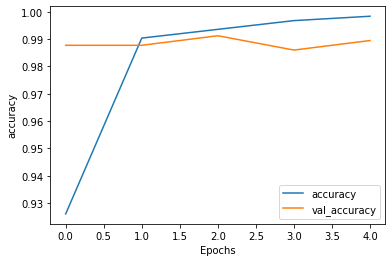

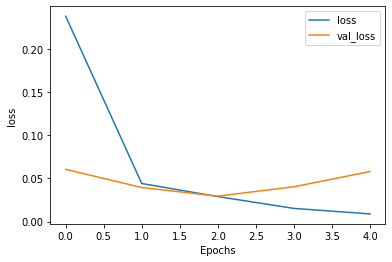

In [41]:
plot_matrics(history, 'accuracy')
plot_matrics(history, 'loss')

In [46]:
sentences = ["Congratulations! you have won 1000 pounds, click on our website", "Your account is temporarily locked, click on this website to win! 120 dollar", "hello! how are you?"]
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print("Congratulations! you have won 1000 pounds, click on our website", model.predict(padded)[0])

print("Your account is temporarily locked, click on this website to win! 120 dollar", model.predict(padded)[1])

print("hello! how are you?", model.predict(padded)[2])

Congratulations! you have won 1000 pounds, click on our website [0.9995463]
Your account is temporarily locked, click on this website to win! 120 dollar [0.9996272]
hello! how are you? [0.00049153]


## First two messages are identified as Spam and last message is identified as not spam
 ### Score predicted by the model,  the closest to 1 is spam, the closest to 0 is not spam


# Accuracy with LSTM - training accuracy: 0.9984, validation accuracy: 0.9895

# GRU

In [50]:
# defining the model woth keras functional API
input = Input(shape=(max_length,))
x = Embedding(vocab_size, embedding_dim, input_length=max_length)(input)
x = GRU(64, return_sequences = True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(32, activation='relu')(x) 
output = Dense(1, activation='sigmoid')(x)
gru_model = Model(input, output)

gru_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [51]:
gru_history = gru_model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels), verbose=2)

Epoch 1/5
157/157 - 7s - loss: 0.3030 - accuracy: 0.8976 - val_loss: 0.0595 - val_accuracy: 0.9843
Epoch 2/5
157/157 - 4s - loss: 0.0438 - accuracy: 0.9892 - val_loss: 0.0309 - val_accuracy: 0.9913
Epoch 3/5
157/157 - 4s - loss: 0.0211 - accuracy: 0.9944 - val_loss: 0.0351 - val_accuracy: 0.9913
Epoch 4/5
157/157 - 4s - loss: 0.0055 - accuracy: 0.9988 - val_loss: 0.0422 - val_accuracy: 0.9913
Epoch 5/5
157/157 - 4s - loss: 0.0021 - accuracy: 0.9992 - val_loss: 0.0477 - val_accuracy: 0.9913


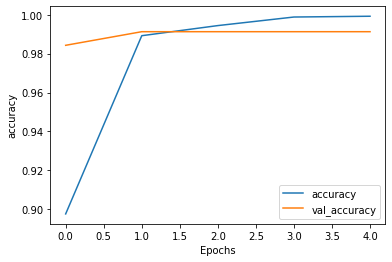

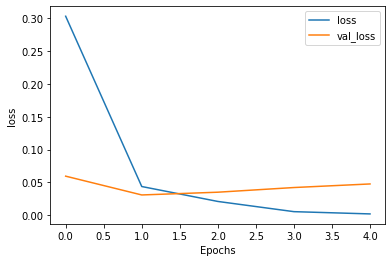

In [52]:
plot_matrics(gru_history, 'accuracy')
plot_matrics(gru_history, 'loss')

# Accuracy with GRU - training accuracy: 0.9992, validation accuracy: 0.9813

# CNN

In [61]:
# defining the model woth keras functional API
input = Input(shape=(max_length,))
x = Embedding(vocab_size, embedding_dim, input_length=max_length)(input)
x = Conv1D(128, 7, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 7, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
cnn_model = Model(input, output)


cnn_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [62]:
cnn_history = cnn_model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels), verbose=2)

Epoch 1/5
157/157 - 3s - loss: 0.1583 - accuracy: 0.9468 - val_loss: 0.0527 - val_accuracy: 0.9808
Epoch 2/5
157/157 - 2s - loss: 0.0287 - accuracy: 0.9928 - val_loss: 0.0511 - val_accuracy: 0.9878
Epoch 3/5
157/157 - 2s - loss: 0.0104 - accuracy: 0.9982 - val_loss: 0.0535 - val_accuracy: 0.9895
Epoch 4/5
157/157 - 2s - loss: 0.0056 - accuracy: 0.9990 - val_loss: 0.0612 - val_accuracy: 0.9878
Epoch 5/5
157/157 - 2s - loss: 0.0033 - accuracy: 0.9996 - val_loss: 0.0711 - val_accuracy: 0.9895


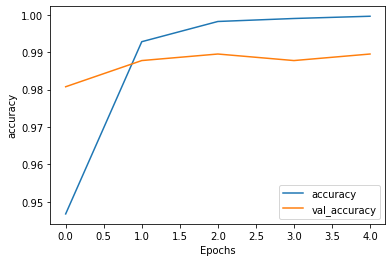

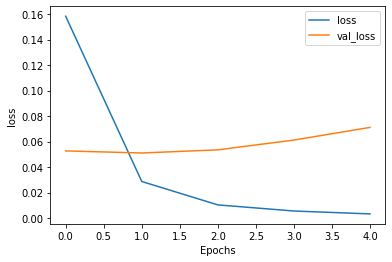

In [63]:
plot_matrics(cnn_history, 'accuracy')
plot_matrics(cnn_history, 'loss')

### CNN is superfast while trainig the network, compared to GRU and LSTM 
## training_accuracy: 0.9996 , validation accuracy: 0.9895

# Training LSTM with sequential API

In [67]:
import tensorflow as tf
lstm_seq_model = tf.keras.Sequential([
  Embedding(vocab_size, embedding_dim, input_length=max_length), 
  LSTM(64, return_sequences = True),
  GlobalMaxPooling1D(),
  Dense(32, activation='relu'),
  Dense(1, activation='sigmoid')
])


lstm_seq_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
lstm_seq_history = cnn_model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels), verbose=2)



Epoch 1/5
157/157 - 2s - loss: 0.0027 - accuracy: 0.9996 - val_loss: 0.0924 - val_accuracy: 0.9878
Epoch 2/5
157/157 - 2s - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.0690 - val_accuracy: 0.9895
Epoch 3/5
157/157 - 2s - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0905 - val_accuracy: 0.9895
Epoch 4/5
157/157 - 2s - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.0817 - val_accuracy: 0.9860
Epoch 5/5
157/157 - 2s - loss: 0.0026 - accuracy: 0.9990 - val_loss: 0.1350 - val_accuracy: 0.9825
